## Python Data fitting with various functions - HW 11 part 2 
Due Friday Nov 10, 2023


Dowload the data "miniDR17.fits" from the TCU Online Week 12:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


You will be using the same data "miniDR17.fits" from the TCU Online Week 12:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outliers!!!!  If you are not sure, ask!!!</b>). 

In [53]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [54]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

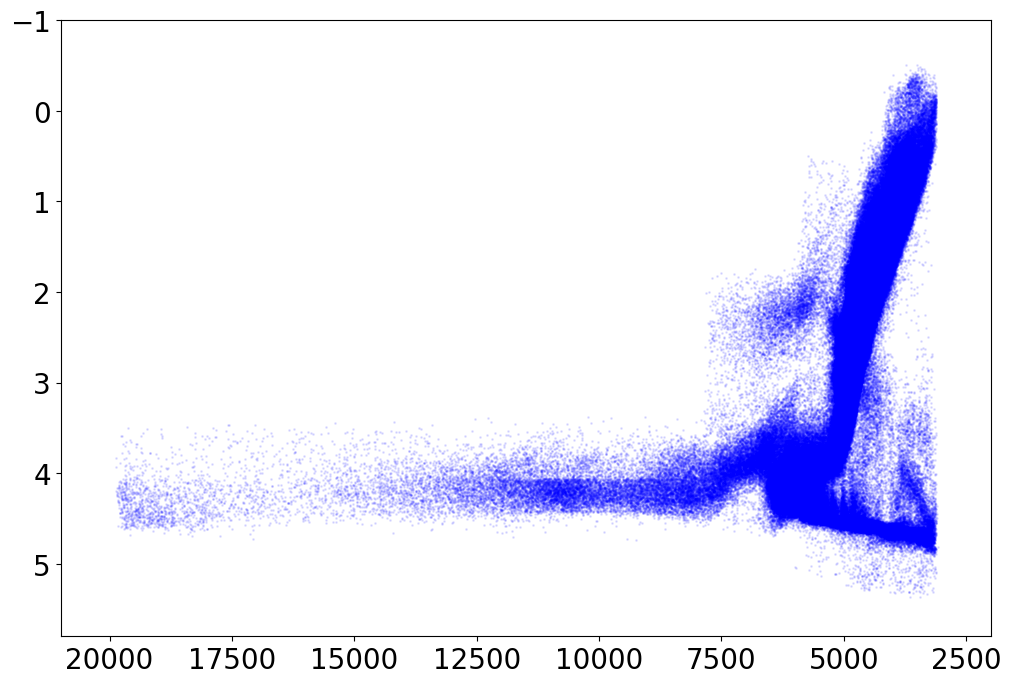

In [3]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.232, 0.054
POLY2: -0.073, -0.317, 0.048
POLY3: 0.075, 0.092, -0.262, 0.045


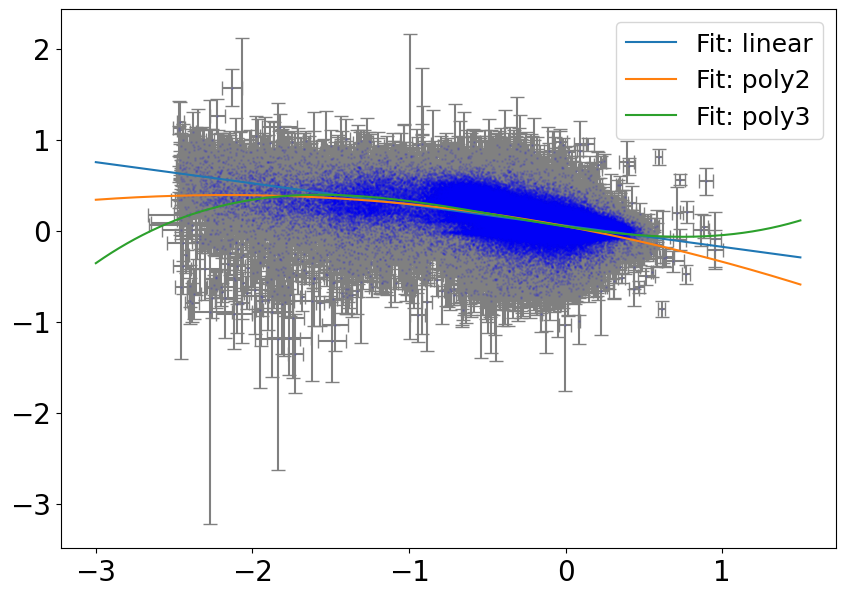

In [55]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > 20) & (~np.isnan(star['Fe_H'])) & (~np.isnan(star['O_FE'])) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                          star['O_FE_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['O_FE_ERR'][cut1],p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## POLY3 FIT (4 parameter)
p3A, p3B, p3C, p3D = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                            star['O_FE_ERR'][cut1],p0=[1,0.02,0,0])
print(f'POLY3: {p3A:.3f}, {p3B:.3f}, {p3C:.3f}, {p3D:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['Fe_H'][cut1]),star['O_FE'][cut1], xerr=(star['Fe_H_ERR'][cut1]), yerr=(abs(star['O_FE_ERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-3,1.5,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly 3fit
ax1.plot(x_plot,poly3(x_plot, p3A, p3B, p3C, p3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
# I believe the Poly3 with values [0.075, 0.092, -0.262, 0.045] is the best option

#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
# No

## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.137, 0.040
POLY2: -0.020, -0.146, 0.041
POLY3: 0.090, 0.129, -0.131, 0.033


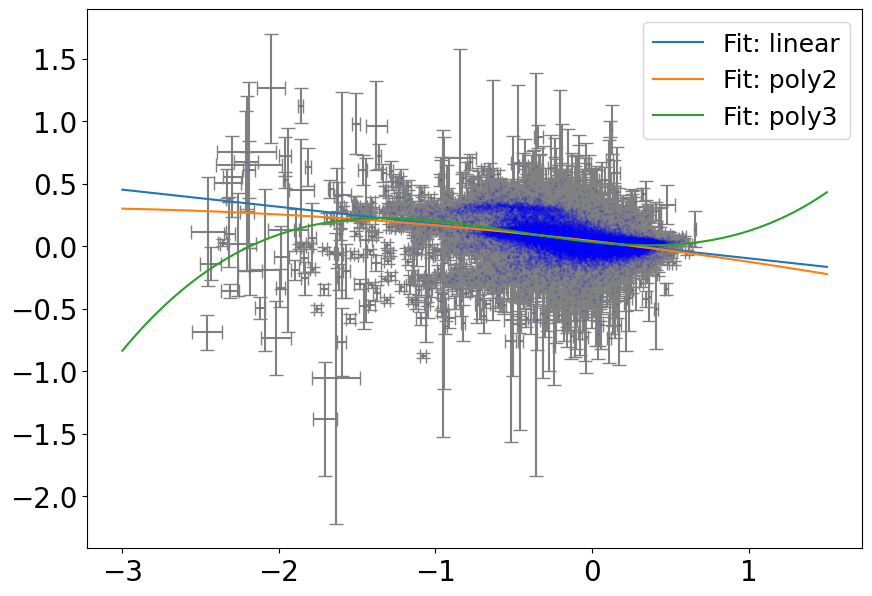

In [56]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -1) & (star['GLAT'] < 1) & (~np.isnan(star['Fe_H'])) & (~np.isnan(star['O_FE'])) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                          star['O_FE_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['O_FE_ERR'][cut1],p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## POLY3 FIT (4 parameter)
p3A, p3B, p3C, p3D = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], \
                            star['O_FE_ERR'][cut1],p0=[1,0.02,0,0])
print(f'POLY3: {p3A:.3f}, {p3B:.3f}, {p3C:.3f}, {p3D:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['Fe_H'][cut1]),star['O_FE'][cut1], xerr=(star['Fe_H_ERR'][cut1]), yerr=(abs(star['O_FE_ERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-3,1.5,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly 3fit
ax1.plot(x_plot,poly3(x_plot, p3A, p3B, p3C, p3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
# I believe the Poly3 with values [0.090, 0.129, -0.131, 0.033] is the best option

#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
# No

## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.000, 0.354
EXPONENTIAL: -0.429, -0.000, 3.242, 4.729
POLY3: 0.000, -0.000, 0.002, -4.025


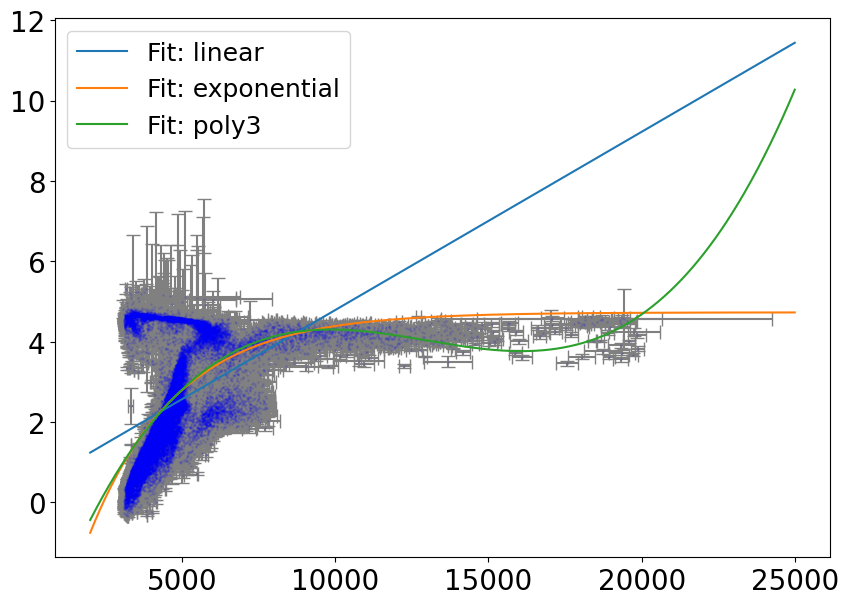

In [64]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLON'] > 340) & (star['GLON'] < 360) & (~np.isnan(star['TEFF'])) & (~np.isnan(star['LOGG'])) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], \
                          star['LOGG_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## EXPO FIT (4 parameter)
exA, exB, exC, exD = mcFit4(exponential, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], \
                            star['LOGG_ERR'][cut1],p0=[-2,-0.0009,4,4])
print(f'EXPONENTIAL: {exA:.3f}, {exB:.3f}, {exC:.3f}, {exD:.3f}')

#=================================================================================
## POLY3 FIT (4 parameter)
p3A, p3B, p3C, p3D = mcFit4(poly3, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], \
                            star['LOGG_ERR'][cut1],p0=[1,.02,0,0])
print(f'POLY3: {p3A:.3f}, {p3B:.3f}, {p3C:.3f}, {p3D:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1],star['LOGG'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1]),star['LOGG'][cut1], xerr=(star['TEFF_ERR'][cut1]), yerr=(abs(star['LOGG_ERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(2000,25000,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,exponential(x_plot, exA, exB, exC, exD), label='Fit: exponential')
#poly 3fit
ax1.plot(x_plot,poly3(x_plot, p3A, p3B, p3C, p3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

In [65]:
# I believe the expfit with values [-0.429, -0.000, 3.242, 4.729] is the best option

#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
# No

## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
NOTE: you will have to create a (J-K) error:  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.000, 1.907


/var/folders/9t/sbgv3z4d4h3dyhbwcrl1dy0r0000gn/T/ipykernel_90724/2418722728.py:23: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x + c) + d


LOGFIT: -0.707, 0.814, -1939.659, 5.941
POLY2: 0.000, -0.001, 3.046


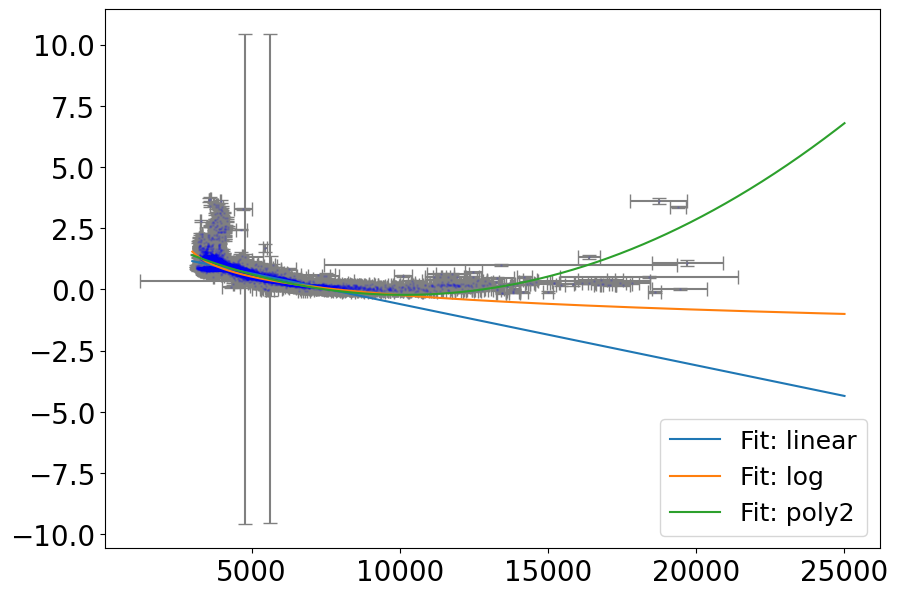

In [66]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['RA'] > 50) & (star['RA'] < 120) & (~np.isnan(star['TEFF'])) & (~np.isnan(star['J'])) & (~np.isnan(star['K'])) &\
     (np.isfinite(star['J'])) & (np.isfinite(star['K'])) & (~np.isnan(star['RA'])) & (~np.isnan(star['J_ERR'])) & \
     (~np.isnan(star['K_ERR'])) & (star['DEC'] < -50)
cut1 = np.where(ct1)[0]
JK_ERR = np.sqrt(star['J_ERR']**2+star['K_ERR']**2)
J_K = star['J']-star['K']
#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['TEFF'][cut1], J_K[cut1], star['TEFF_ERR'][cut1], \
                          JK_ERR[cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## LOG FIT (4 parameter)
lgA, lgB, lgC, lgD = mcFit4(logfit, star['TEFF'][cut1], J_K[cut1], star['TEFF_ERR'][cut1], \
                            JK_ERR[cut1],p0=[-.5,1,-1000 ,2])
print(f'LOGFIT: {lgA:.3f}, {lgB:.3f}, {lgC:.3f}, {lgD:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
p2A, p2B, p2C = mcFit3(poly2, star['TEFF'][cut1], J_K[cut1], star['TEFF_ERR'][cut1], \
                            JK_ERR[cut1],p0=[1,.02,0])
print(f'POLY2: {p2A:.3f}, {p2B:.3f}, {p2C:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1],J_K[cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1]),J_K[cut1], xerr=(star['TEFF_ERR'][cut1]), yerr=(abs(JK_ERR[cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(3000,25000,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#log2 fit
ax1.plot(x_plot,logfit(x_plot, lgA, lgB, lgC, lgD), label='Fit: log')
#poly 3fit
ax1.plot(x_plot,poly2(x_plot, p2A, p2B, p2C), label='Fit: poly2')

plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
# I believe the logfit with values [-0.707, 0.814, -1939.659, 5.941] is the best option 
# even though it is givng me errors, it was still able to plot a fairly well fitting line.

#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
# No

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHELIO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.001, -3.966
POLY3: -0.000, 0.014, -1.780, 27.961
COSFIT: 49.830, 0.023, 0.863, 0.584


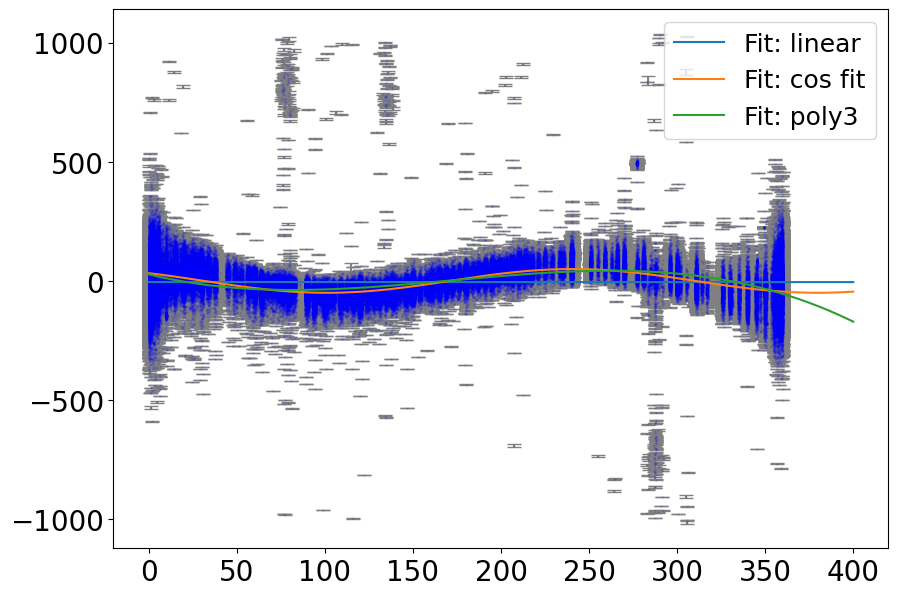

In [67]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -10) & (star['GLAT'] < 10) & (~np.isnan(star['GLON'])) & \
     (~np.isnan(star['VHELIO_AVG'])) & (~np.isnan(star['VERR']))
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['GLON'][cut1], star['VHELIO_AVG'][cut1], \
                          star['VERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY3 FIT (4 parameter)
p3A, p3B, p3C, p3D = mcFit4(poly3, star['GLON'][cut1], star['VHELIO_AVG'][cut1], \
                            star['VERR'][cut1],p0=[1,0.02,0,0])
print(f'POLY3: {p3A:.3f}, {p3B:.3f}, {p3C:.3f}, {p3D:.3f}')

#=================================================================================
## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['GLON'][cut1], star['VHELIO_AVG'][cut1], \
                            star['VERR'][cut1],p0=[200,0.02,1,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['GLON'][cut1],star['VHELIO_AVG'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['GLON'][cut1]),star['VHELIO_AVG'][cut1], yerr=(abs(star['VERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,400,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#cos fit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cos fit')
#poly 3fit
ax1.plot(x_plot,poly3(x_plot, p3A, p3B, p3C, p3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
# I believe the cosfit with values [49.830, 0.023, 0.863, 0.584] is the best option

#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
# Maybe, but the other groups are hard to isolate

## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.065, 0.835
POLY3: -0.000, -0.001, 0.098, 0.732


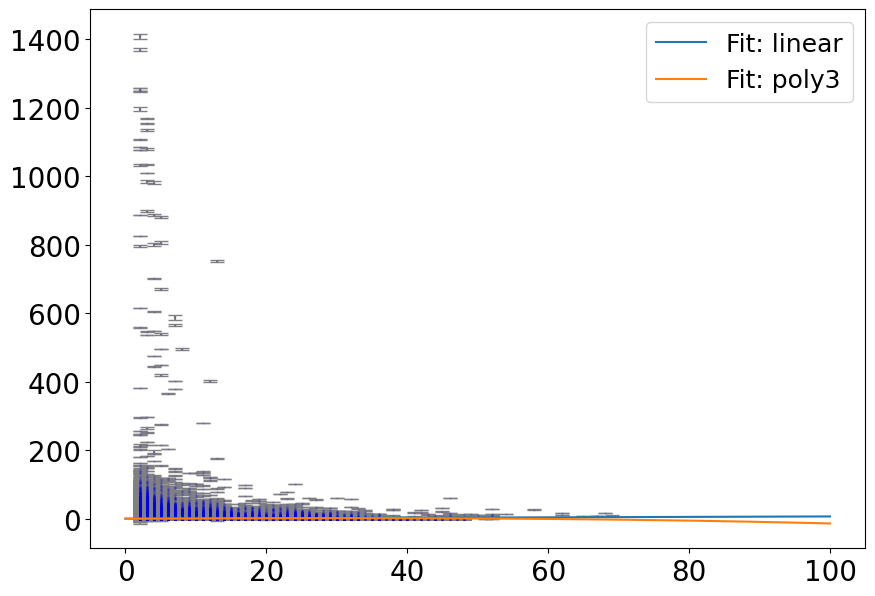

In [69]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['NVISITS'] >= 2) & (~np.isnan(star['NVISITS'])) & \
     (~np.isnan(star['VSCATTER'])) & (~np.isnan(star['VERR'])) &(star['VERR']<1000)
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['NVISITS'][cut1], star['VSCATTER'][cut1], \
                          star['VERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY3 FIT (4 parameter)
p3A, p3B, p3C, p3D = mcFit4(poly3, star['NVISITS'][cut1], star['VSCATTER'][cut1], \
                            star['VERR'][cut1],p0=[1,0.02,0,0])
print(f'POLY3: {p3A:.3f}, {p3B:.3f}, {p3C:.3f}, {p3D:.3f}')

#=================================================================================
## EXPO FIT (4 parameter)
#exA, exB, exC, exD = mcFit4(exponential, star['NVISITS'][cut1], star['VSCATTER'][cut1], \
#                            star['VERR'][cut1],p0=[600, -.5, 0, 0])
#print(f'EXPONENTIAL: {exA:.3f}, {exB:.3f}, {exC:.3f}, {exD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['NVISITS'][cut1],star['VSCATTER'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['NVISITS'][cut1]),star['VSCATTER'][cut1], yerr=(abs(star['VERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,100,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#exp fit
#ax1.plot(x_plot,exponential(x_plot, exA, exB, exC, exD), label='Fit: exponential')
#poly 3fit
ax1.plot(x_plot,poly3(x_plot, p3A, p3B, p3C, p3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

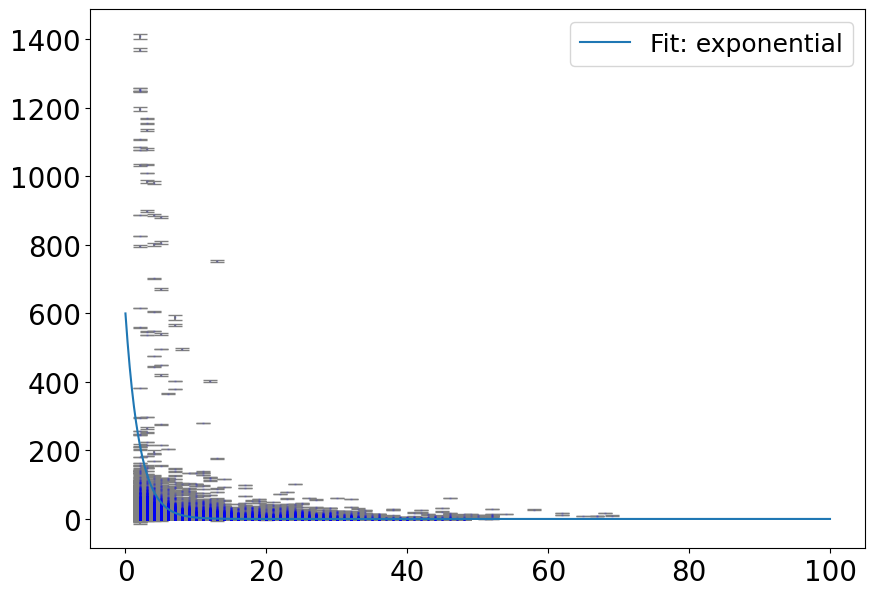

In [70]:
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['NVISITS'] >= 2) & (~np.isnan(star['NVISITS'])) & \
     (~np.isnan(star['VSCATTER'])) & (~np.isnan(star['VERR'])) & (star['VERR']<1000)
cut1 = np.where(ct1)[0]

fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['NVISITS'][cut1],star['VSCATTER'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['NVISITS'][cut1]),star['VSCATTER'][cut1], yerr=(abs(star['VERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)

# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,100,1000) # X-PLOTING FOR FITS


ax1.plot(x_plot,exponential(x_plot, 600, -.5, 0, 0), label='Fit: exponential')


plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
# I believe the Exponential with values similar to [600, -.5, 0, 0] is the best option.
# I could not get it to plot throughout all my tries, but the best fit I created myself looks much 
# better than the linear or poly3 fit lines so I am putting it as the best parameters that I could find

#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
# No

## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.013, 0.016
POLY2: 0.024, 0.038, 0.017
POLY3: -0.021, -0.018, 0.026, 0.018


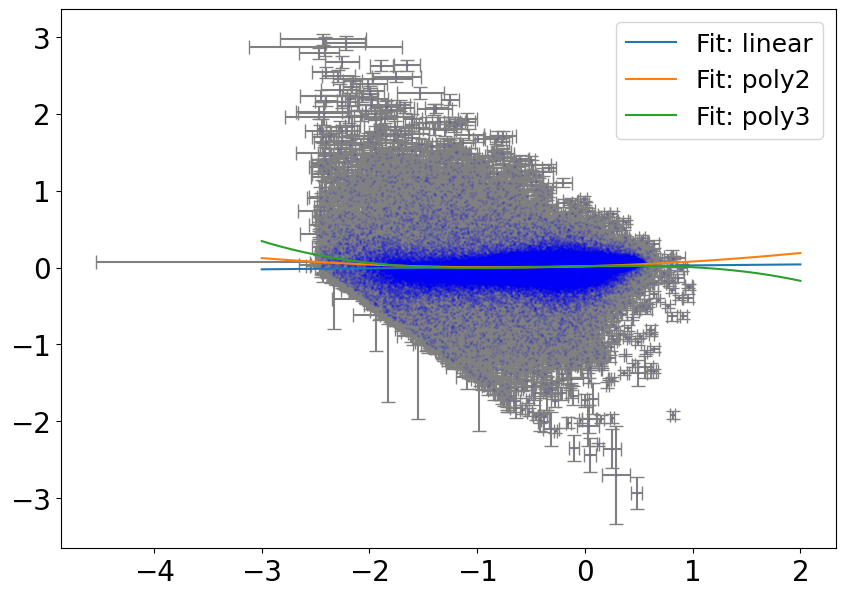

In [68]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & (~np.isnan(star['Fe_H'])) & \
     (~np.isnan(star['Fe_H_ERR'])) & (~np.isnan(star['NI_FE'])) & (~np.isnan(star['NI_FE_ERR'])) &\
     (star['Fe_H_ERR']<100) & (star['NI_FE_ERR']<100)
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                          star['NI_FE_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
p2A, p2B, p2C = mcFit3(poly2, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                            star['NI_FE_ERR'][cut1],p0=[1,.02,0])
print(f'POLY2: {p2A:.3f}, {p2B:.3f}, {p2C:.3f}')

#=================================================================================
## POLY3 FIT (4 parameter)
p3A, p3B, p3C, p3D = mcFit4(poly3, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                            star['NI_FE_ERR'][cut1],p0=[1,.02,0,0])
print(f'POLY3: {p3A:.3f}, {p3B:.3f}, {p3C:.3f}, {p3D:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['Fe_H'][cut1],star['NI_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['Fe_H'][cut1]),star['NI_FE'][cut1], xerr=(star['Fe_H_ERR'][cut1]), yerr=(abs(star['NI_FE_ERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-3,2,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, p2A, p2B, p2C), label='Fit: poly2')
#poly 3fit
ax1.plot(x_plot,poly3(x_plot, p3A, p3B, p3C, p3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
# I believe the linear with values [0.013, 0.016] is the best option but there are not really any good fits 
# based on the unique spreak over a unique shape of the data around the large mass of data points

#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
# No